In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
from matplotlib import font_manager as fm, rcParams
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

from pathlib import Path


from umap.umap_ import UMAP

from pointgrid import align_points_to_grid

#hdbscan
import hdbscan

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 
               'G': 'Sources', 'H': 'Iconography', 'J': 'Ornament','K': 'Kat and K', 'L': 'Congress Publications', 'M': 'Art in General',
                'N': 'Architecture', 'O':'Sculpture', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art, Museum Studies', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 
               'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines', ' ': 'None'}


custom_colours = ["#EA522B", "#EFD4D1", "#2A4978", "#8BDBE1", "#ECA19D", "#B48E36", "#E1DCE0", "#B8BFCE", "#E0DCD1", "#91C5E4", 
                  "#6E8EAC", "#D2E7E0", "#ECD096", "#6C9686", "#E6E10F", "#9D4B37", "#A3B49D", "#BDC920", "#DBE3E5", "#6A8B8D", "#EFB3D1"]
custom_cmap = ListedColormap(custom_colours)

In [3]:
# Import
path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)
df.inventory_year = df.inventory_year.fillna(0).astype(int)
df = df.fillna('')

# 30'000 sample points for fast plotting
# df = df.sample(30000)

In [4]:
# text cols for wordclouds, cluster cols for clustering
text_cols = ['text', 'text_3', 'text_2', 'text_1']
cluster_cols = ['sig_lev_1', 'text_2', 'text_3']

# Perform one-hot encoding on the cluster_cols
df_cluster_1 = pd.get_dummies(df[cluster_cols[0]])
df_cluster_2 = pd.get_dummies(df[cluster_cols[:3]])


In [5]:
#Normalize 
def normalize(emb):

    embedding = emb * 100 # Multiply by 100
    embedding = align_points_to_grid(embedding)

    # Swap axes for horizontal position

    # ptp = np.ptp(embedding, axis=0)
    # if ptp[1]> ptp[0]:
    #     embedding[:, [1, 0]] = embedding[:, [0, 1]]

    # Set range of values normalized to dimension with higher extent

    extent = (embedding[:,0].min(), embedding[:,0].max()) if (embedding[:,0].max() - embedding[:,0].min()) > (embedding[:,1].max() - embedding[:,1].min()) else (embedding[:,1].min(), embedding[:,1].max())
    resolution = (-1000, 1000)

    embedding[:, 0] = np.interp(embedding[:,0], extent, resolution)
    embedding[:, 1] = np.interp(embedding[:,1], extent, resolution)

    # # Set origin at the middle

    # ptp = np.ptp(embedding, axis=0)  
    # embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
    # embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

    embedding = embedding.astype(int) # Set integer

    return embedding

## 1. embedding: TF-IDF on titles

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


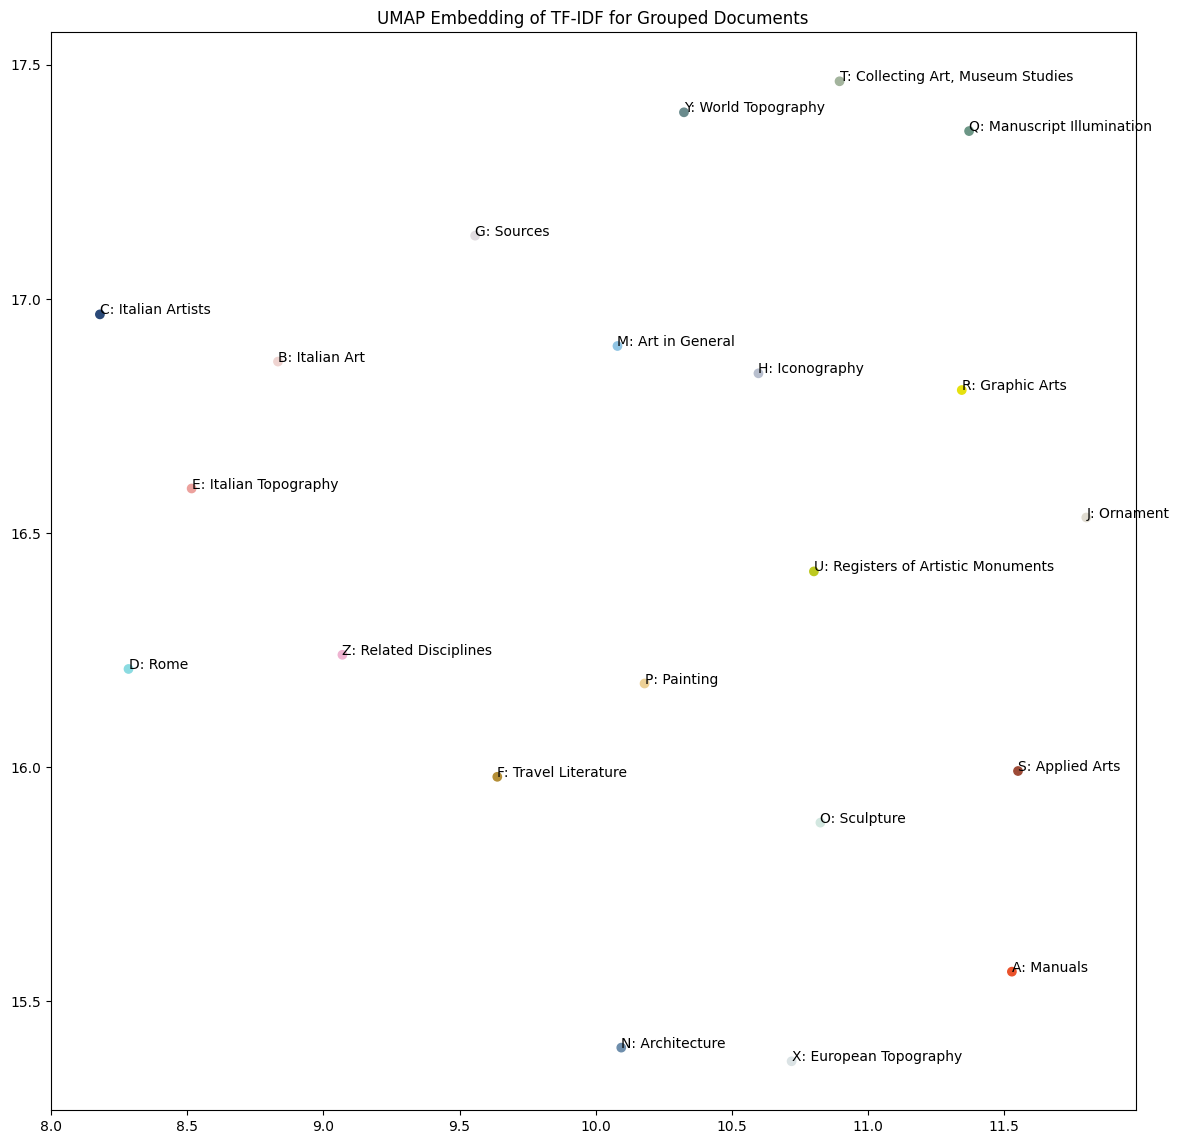

In [6]:
n_neighbors = 30
metric = 'cosine'
min_dist = 0.1

# TODO: languages? create statistics for languages

# Group the documents based on sig_lev_1
grouped = df.groupby('sig_lev_1')

# Create one long text out of the titles for each group
group_texts = {}
for group_name, group_df in grouped:
    titles = group_df['title'].tolist()
    long_text = ' '.join(titles)
    group_texts[group_name] = long_text

# Compute TF-IDF based on the long texts
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(group_texts.values())

#  Run UMAP on the TF-IDF matrix
umap_embedding = UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric).fit_transform(tfidf_matrix)

# Plot the points on the UMAP embedding and add labels
fig, ax = plt.subplots(figsize=(14, 14))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=range(len(group_texts)), cmap=custom_cmap)
for i, group_name in enumerate(group_texts.keys()):
    label = group_name + ': ' + subject_dict[group_name]  # Get the value from subject_list dictionary
    plt.text(umap_embedding[i, 0], umap_embedding[i, 1], label, fontsize=10)

plt.title("UMAP Embedding of TF-IDF for Grouped Documents")
plt.show()


# 2. embedding: running UMAP on second level

In [7]:
# Umap embedding for each cluster
embeddings_2 = []

for group_name, group_df in grouped:

    n_neighbors = 30
    metric = 'russellrao'
    min_dist = 0.1

    # Get the indices of the current group
    group_indices = group_df.index

    # Extract corresponding rows from df_cluster_2
    data = df_cluster_2.loc[group_indices]

    # Apply UMAP to the cluster again
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist,
                spread=1.0, random_state=42, verbose=False)
    x_umap = umap.fit_transform(data)

    embeddings_2.append(x_umap)

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellra

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/seaborn/relational.py:573

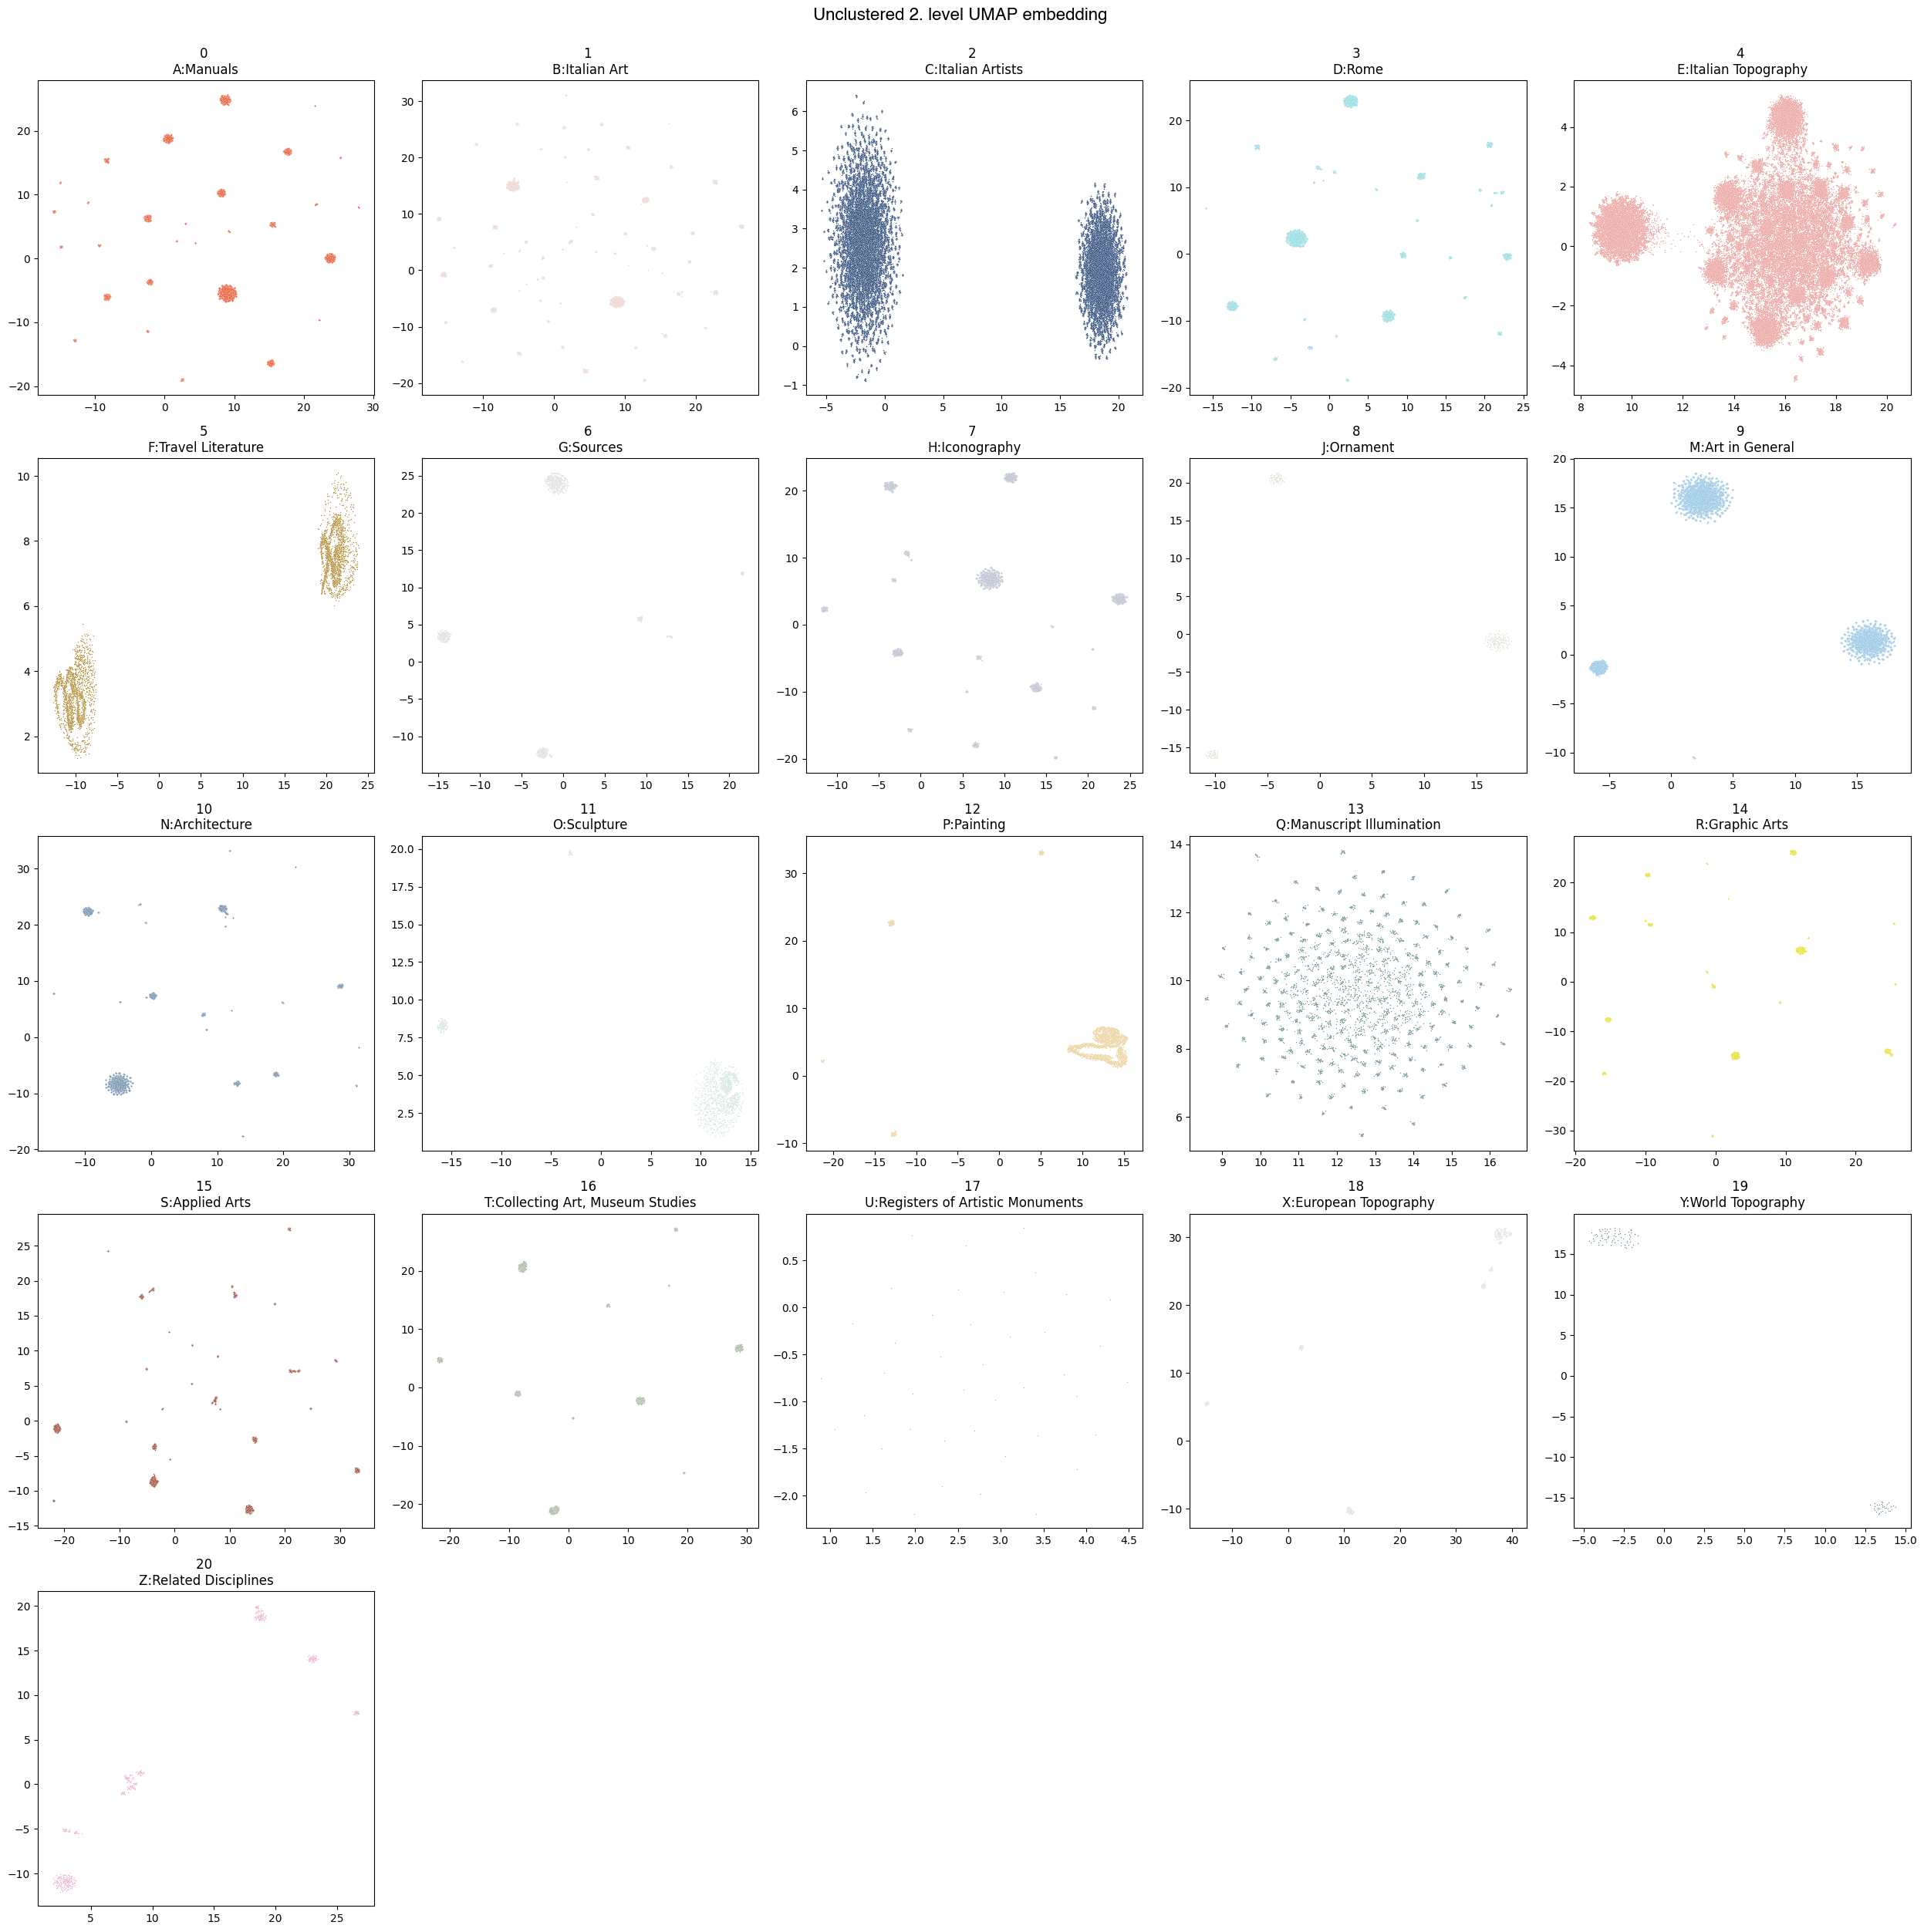

In [9]:
n_clusters = len(grouped)
n_rows = int(np.ceil(np.sqrt(n_clusters)))
n_cols = int(np.ceil(n_clusters / n_rows))

# Create the subplots for the level 2 embeddings
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows * 5, n_cols * 5))
axes = axes.flatten()

for i, (group_name, group_df) in enumerate(grouped):

    ax = axes[i]

    emb = embeddings_2[i]
    # labels = clusters_2[i][0]
    # clustered = clusters_2[i][1]

    rows = df.loc[group_df.index, :]
    order = sorted(rows.text_2.unique())
    color = custom_cmap(i / (n_clusters - 1))

    # Clustered datapoints
    sns.scatterplot(x=emb[:, 0], 
                    y=emb[:, 1], 
                    c=color,
                    ax=ax, 
                    s=1,)
        
    ax.set_title('{} \n{}:{}'.format(i, group_name, subject_dict[group_name]))

# Hide any extra subplots
for j in range(n_clusters, n_rows * n_cols):
    fig.delaxes(axes[j])

fig.suptitle('Unclustered 2. level UMAP embedding', fontsize=16, y=1, font='Helvetica')
plt.tight_layout()
plt.show()


/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_1435/2501960617.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(assembled_embedding[group_indices, 0], assembled_embedding[group_indices, 1], c=color, s=0.5)


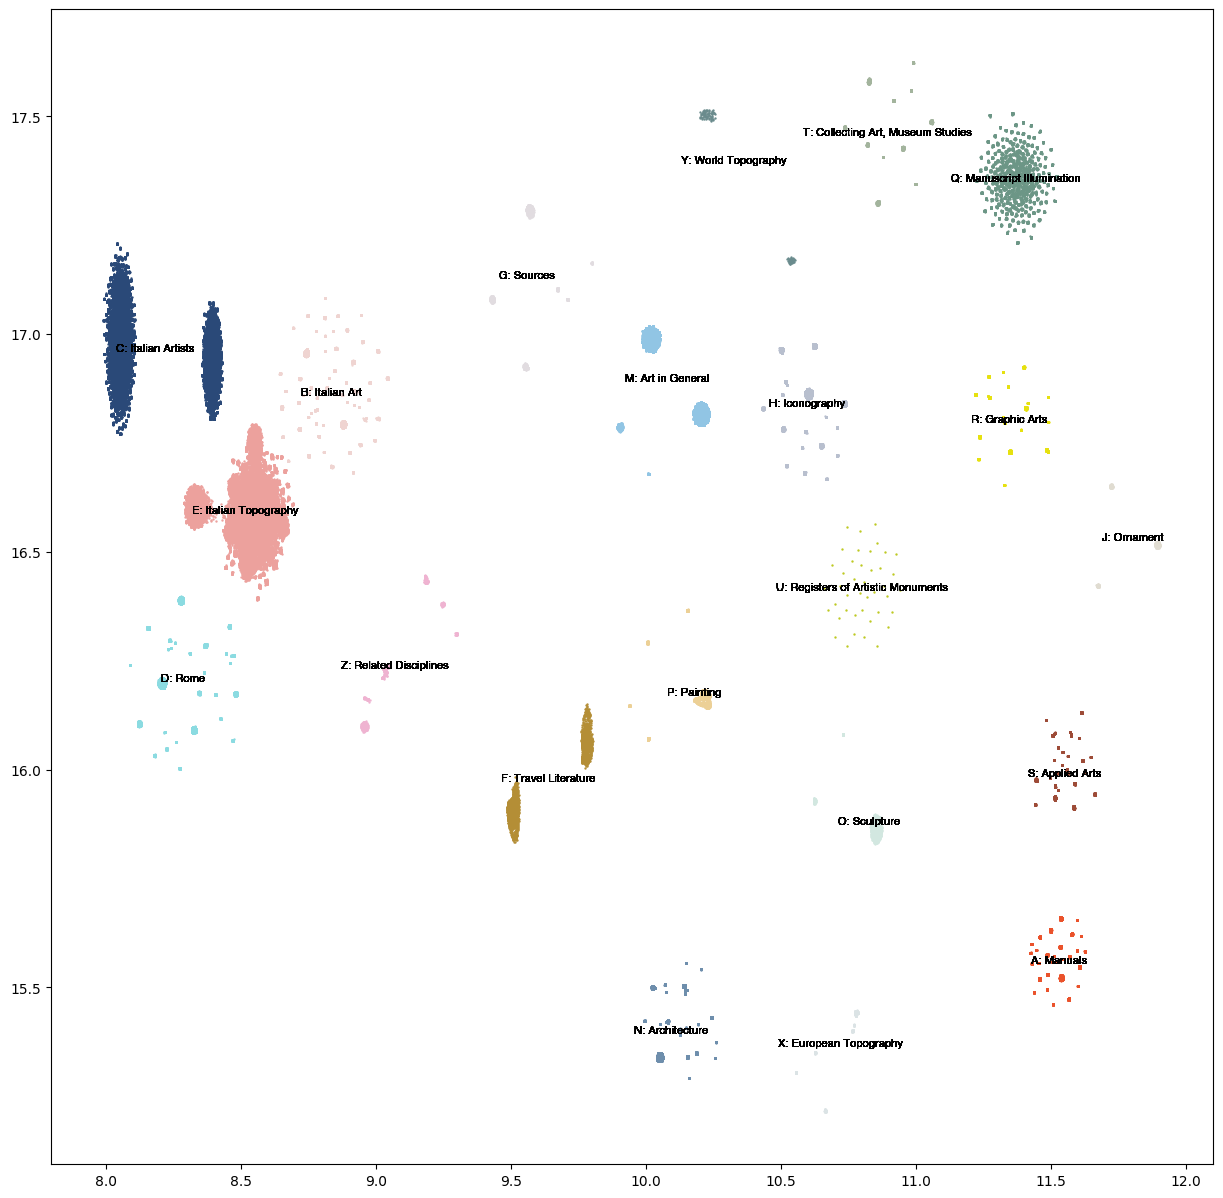

In [30]:
size = sum(len(group_df) for _, group_df in grouped)
assembled_embedding = np.empty((size, 2)) 
n_groups = len(grouped)

fig, ax = plt.subplots(figsize=(15, 15))

for i, (group_name, group_df) in enumerate(grouped):
    centroid_1 = umap_embedding[i] 
    emb_2 = embeddings_2[i]
    group_indices = group_df.index
    color = custom_cmap(i / (n_groups - 1))

       
    scale_factor = np.ptp(umap_embedding[i] , axis=0) / np.ptp(emb_2, axis=0)
    scaled_emb_2 = emb_2 * scale_factor * 0.05 # scale factor 

    centroid_2_scaled = np.mean(scaled_emb_2, axis=0)
    centroid_diff = centroid_1 - centroid_2_scaled
    shifted_emb_2= scaled_emb_2 + centroid_diff

    assembled_embedding[group_indices] = shifted_emb_2
    
    plt.scatter(assembled_embedding[group_indices, 0], assembled_embedding[group_indices, 1], c=color, s=0.5)
    for i, group_name in enumerate(group_texts.keys()):
        label = group_name + ': ' + subject_dict[group_name]  # Get the value from subject_list dictionary
        plt.text(umap_embedding[i, 0], umap_embedding[i, 1], label, ha='center', va='center', 
                    fontsize=8, font='Helvetica')



    

